In [3]:
library(data.table)
# library(pracma) # only needed for moving-average plot
load('../data/mutation_type_pd.rda') # probabilities of each mutation type

In [4]:
birthrate <- function(nd, np, sd, sp, tau) { # probability of birth per timestep
    return((((1+sd)^nd)/((1+sp)^np))*tau)
}
delta_ncells <- function(B, D, ncells) { # change in number of cells for a clone
    return (max(ncells + rbinom(1,ncells,min(B,1))-rbinom(1,ncells,min(D,1)),0))
}
get_mu_i <- function(B, mu) {return(mu*B)} # mutation rate of clone i: proportional to birth rate
get_ntrans <- function(ncells, mu_i) {return (rbinom(1,ncells,mu_i))} # number of transpositions in current clone

In [5]:
run_sim <- function(N0, mu, tau, NT, sd, sp, maxNClones) {

    Pop <- data.table(ncells=rep(0,maxNClones),nd=rep(0,maxNClones),np=rep(0,maxNClones),B=rep(0,maxNClones),mu_i=rep(0,maxNClones))
    Pop[1:2,c('ncells','nd','np'):=list(c(N0-1,1),c(0,1),c(0,0))] # populations are initialized with a driver mutation in a single cell
    Pop[1:2,B := mapply(birthrate,nd,np,sd,sp,tau)]
    Pop[1:2,mu_i := mapply(get_mu_i, B, mu)]

    N <- rep(0,NT)

#     ptm <- proc.time()
    for (ii in 1:NT) {

        clog <- Pop$ncells>0 # get logical array for indices of active (# cells >0) clones
        
        ntrans <- sum(mapply(get_ntrans,Pop$ncells[clog],Pop$mu_i[clog])) # get number of pass/driver mutations
        if (ntrans > 0) {
            
            rownew <- which(Pop$ncells==0)[1] # find first row of the data table with ncells==0

            types <- sample(1:2,ntrans,replace=TRUE,prob=c(0.0001,0.9999)) # sample mutation types
            nmu <- length(types) # total number of passenger and drivers

            sampctr <- sample(rep(1:maxNClones,Pop$ncells),nmu,replace=FALSE) # list clone id of each cell; sample without replacement
            ctab <- table(sampctr)
            cids <- as.integer(names(ctab)) # get row ids of sampled clones
            set(Pop,cids,1L,Pop[cids,1L] - as.integer(ctab)) # remove cells from sampled clones

            # Populate the new rows representing new clones
            Pop[rownew:(rownew+nmu-1), c("ncells","nd","np"):=list(1, Pop[sampctr]$nd+((types==1)*1), Pop[sampctr]$np+((types==2)*1))]
            Pop[rownew:(rownew+nmu-1), B := mapply(birthrate, nd, np, sd, sp, tau)]
            Pop[rownew:(rownew+nmu-1), mu_i := mapply(get_mu_i, B, mu)]
        }

        N[ii] <- sum(Pop$ncells) # get current number of cells
        if (N[ii]>=2*N0) {break} # simulation stops if population has grown by 5X
        D <- N[ii]*tau/N0        # compute death rate
        Pop[Pop$ncells>0, ncells:=mapply(delta_ncells, B, D, ncells)] # update number of cells for all clones
        Pop <- Pop[order(Pop$ncells,decreasing=TRUE),] # order data.table by ncells

    }
#     print(proc.time() - ptm)

    return(list(Pop,N))

}


### Define parameters

In [25]:
# Initial number of cells
N0 <- 2000
# Probability of passenger or driver L1 insertion per generation per cell
mu <- 0.05
# Time resolution: number of timesteps per birth of a cell with birth rate 1
tau <- 2
tau <- 1/tau
# Number of time steps
NT <- 5e3
# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- 2000
# Driver and passenger mutation selection strengths
sd <- .1
sp <- .01

ncells,nd,np,B,mu_i
63,5,34,0.5741253,0.02870627
52,5,34,0.5741253,0.02870627
51,5,34,0.5741253,0.02870627
43,5,35,0.5684409,0.02842205
39,5,36,0.5628128,0.02814064
29,5,37,0.5572404,0.02786202


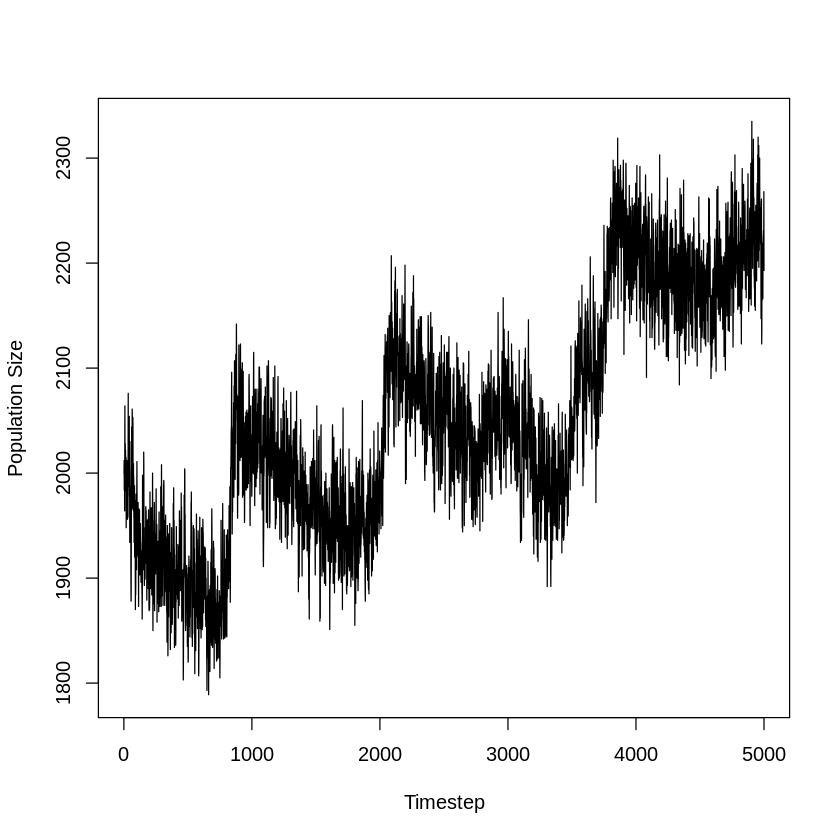

In [26]:
out <- run_sim(N0, mu, tau, NT, sd, sp, maxNClones)
Pop <- out[[1]]
N <- out[[2]]

head(Pop)
plot(1:NT,N,type='l',xlab='Timestep',ylab='Population Size')
# plot((1:NT)*tau,movavg(N,200,'s'),type='l',xlab='Generation',ylab='Population Size')